## Dogs v Cats super-charged!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz=299
arch=resnext50
bs=28

In [3]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5) # ps is dropout percent

100%|██████████| 72/72 [00:41<00:00,  1.74it/s]


In [5]:
learn.fit(1e-2, 1)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.0423  0.02311 0.99306]                             



In [6]:
learn.fit(1e-2, 2, cycle_len=1)　# augumentation

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[0.      0.03657 0.01868 0.99454]                             
[1.      0.0347  0.02078 0.99355]                             



In [7]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [8]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.0321  0.01714 0.99355]                             
[1.      0.03654 0.0174  0.99405]                             
[2.      0.0262  0.01662 0.99454]                             



In [9]:
learn.save('224_all_50')

In [9]:
learn.load('224_all_50')

In [12]:
log_preds,y = learn.TTA() # (5, 2000, 2), (2000,)
#accuracy(log_preds,y) # This does not work
accuracy(np.mean(np.exp(log_preds), 0),y) 

#Source:   
#def accuracy(preds, targs):
#    preds = np.argmax(preds, axis=1)
#    return (preds==targs).mean()
#File:      ~/fastai/courses/dl1/fastai/metrics.py

0.995

## Analyzing results

In [16]:
# This does not work
# preds = np.argmax(log_preds, axis=1)
# probs = np.exp(log_preds[:,1])

# from lesson1.ipynb
probs = np.mean(np.exp(log_preds),0) 
preds = np.argmax(probs, axis=1)
probs = probs[:, 1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  5 995]]


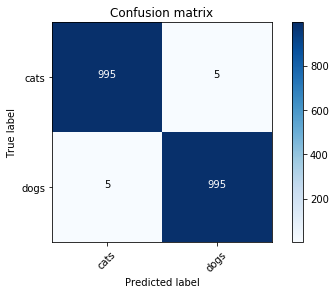

In [17]:
plot_confusion_matrix(cm, data.classes)

In [18]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


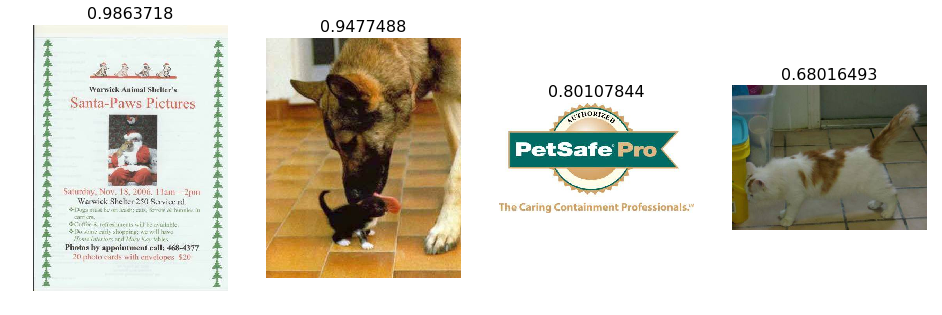

In [19]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


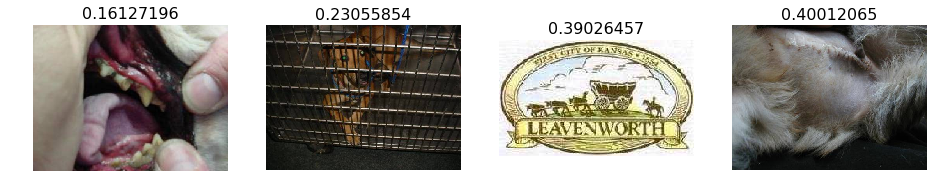

In [20]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")